## MSE 

In [1]:
import os
from pathlib import Path
import numpy as np

from matplotlib import pyplot as plt
import tikzplotlib

In [2]:
# Approximate dynamics (TODO: fixa, för stämmer ej (eller ta bort denna notebook))

def f(u0, t, c, r, s, l):
    
    n = s * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) + c * (l * u0 - s)
    d = l * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) - 2 * r * (l * u0 - s)
    
    return n / d


def u(u0, t, c, r, s, l):
    
    u1 = f(u0, t, 0.96 * c, 0.4 * r, s, l)
    u2 = f(u0, t, 0.4 * c, 0.96 * r, s, l)
    
    ref = ((2 * u1 * r) < c)
    
    return ref * u1 + (1 - ref) * u2    

In [3]:
# MSE 

def z_true(s, l, e):
    return s / l - e / np.sqrt(l)


def mse_global(s, l, u):
    return (s / l - u)**2


def mse_true(s, l, e, u):
    return (z_true(s, l, e) - u)**2


def mse_train(c, r, s1, s2, l1, l2, d, p, u0, t):
    
    return ((d - p) / d) * l1 * mse_global(s1, l1, u(u0, t, c, r, s1, l1)), (p / d) * l2 * mse_global(s2, l2, u(u0, t, c, r, s2, l2))


def mse_test(c, r, s1, s2, l1, l2, e1, e2, d, p, u0, t):
    
    return ((d - p) / d) * l1 * mse_true(s1, l1, e1, u(u0, t, c, r, s1, l1)), (p / d) * l2 * mse_true(s2, l2, e2, u(u0, t, c, r, s2, l2))  

In [4]:
def plot_res(res1, res2, t_range, it_range, it="", titles=["Train", "Test"], vmax=None, log_x_scale=True, log_y_scale=True, fig_name="test"):
    
    fig, ax = plt.subplots(1, 2, figsize = (12, 5))
    
    
    if log_x_scale:
        new_ticks_x = np.linspace(0, res1.shape[0] - 1, int(np.log10(t_range.max())) + 1).astype(int)
    else:
        new_ticks_x = np.linspace(0, res1.shape[0] - 1, 5).astype(int)

    new_ticks_y = np.linspace(0, res1.shape[0] - 1, 5).astype(int)


    im1 = ax[0].imshow(res1, cmap="viridis", vmax=vmax)
    im2 = ax[1].imshow(res2, cmap="viridis", vmax=vmax)
    
    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    
    for i in range(2):
        ax[i].set_title(titles[i]) 
        
        ax[i].set_xlabel("t")
        ax[i].set_xticks(new_ticks_x)
        
        if log_x_scale:
            ax[i].set_xticklabels([f"$10^{{{x}}}$" for x in np.round(np.log10(t_range[new_ticks_x]), 1).astype(int)]) # OBS: AVRUNDNINGEN!!!
        else:
            ax[i].set_xticklabels(t_range[new_ticks_x].astype(int)) 

        ax[i].set_ylabel(it)
        ax[i].set_yticks(new_ticks_y)
        
        if log_y_scale:
            ax[i].set_yticklabels([f"10^{{{x}}}" for x in np.round(np.log10(it_range[new_ticks_y]), 2)]) # OBS: AVRUNDNINGEN!!!
        else:
            ax[i].set_yticklabels(np.round(it_range[new_ticks_y], 2)) # OBS: AVRUNDNINGEN!!!
            
    savedir="res/mse_approx/"
    if not os.path.exists(Path(savedir)):
        os.mkdir(Path(savedir))
            
    #tikzplotlib.save(Path(savedir + fig_name + "_surface_plot.tikz"))
    plt.savefig(Path(savedir + fig_name + "_surface_plot.png"))
    
    plt.show()
    
def plot_curves(res1, res2, t_range, it_range, it="", titles=["Train", "Test"], ylim=None, log_x_scale=True, log_y_scale=True, fig_name="test"):
    
    fig, ax = plt.subplots(1, 2, figsize = (12, 5))
        
        
    for i in range(0, res1.shape[-1], int(res1.shape[-1] / 10)) :
        
        if log_y_scale:
            lab = it + " = " + fr"10^{{{np.round(np.log10(it_range[i]), 2)}}}"
        else:
            lab = it + " = " + str(round(it_range[i], 2))
            
        ax[0].plot(t_range, res1[i, :], label=lab)
        ax[1].plot(t_range, res2[i, :], label=lab)
    
    for i in range(2):
                
        ax[i].set_title(titles[i]) 
        ax[i].legend(loc=2)

        
        ax[i].set_xlabel("t")
        ax[i].set_ylabel("MSE")
        
        ax[i].set_ylim([0, ylim])
        
        if log_x_scale:
            ax[i].set_xscale("log")

    savedir="res/mse_approx/"
    if not os.path.exists(Path(savedir)):
        os.mkdir(Path(savedir))
            
    #tikzplotlib.save(Path(savedir + fig_name + "_example_plots.tikz"))
    plt.savefig(Path(savedir + fig_name + "_example_plots.png"))
    
    plt.show()

# Test example

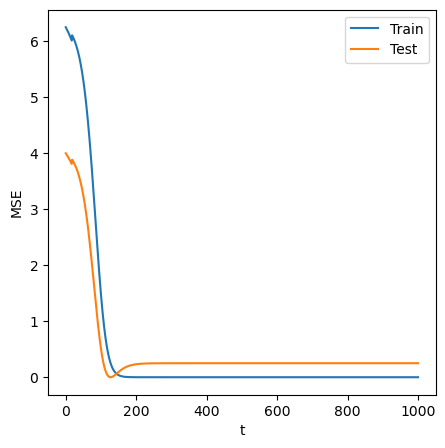

In [5]:
# Test

# Hps
tau = 1000
ts = np.linspace(0, tau, tau)

c, r = 0.001, 0.01
s = 2.5
l1, l2 = 1, 10
d = 10
p1, p2 = 0, 9
u0 = 0.001
e = 0.5

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

mset_1, mset_2 = mse_train(c, r, s, s, l1, l2, d, p1, u0, ts)
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, l2, e, e, d, p1, u0, ts)
ax.plot(ts, mset_1 + mset_2, label = "Train") 
ax.plot(ts, mseg_1 + mseg_2, label = "Test")

ax.set_xlabel("t")
ax.set_ylabel("MSE")
ax.legend()

plt.show()

# Changing $l2=\lambda_2$

# c < r

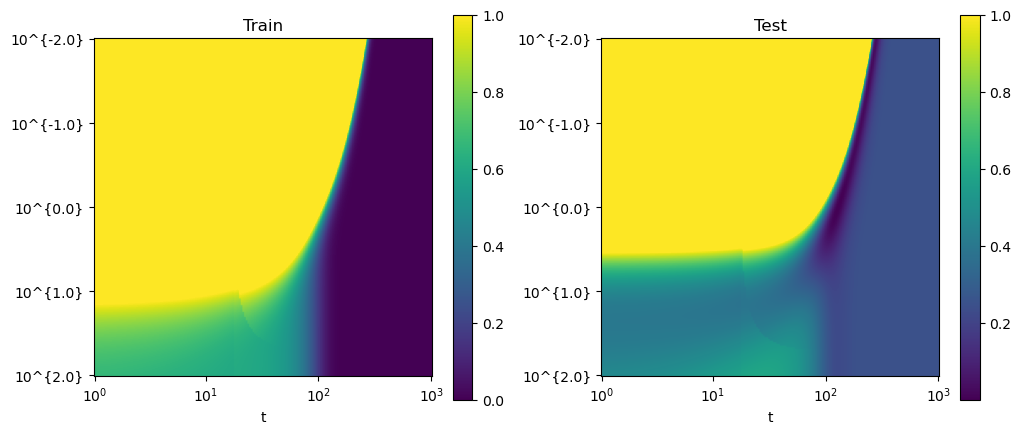

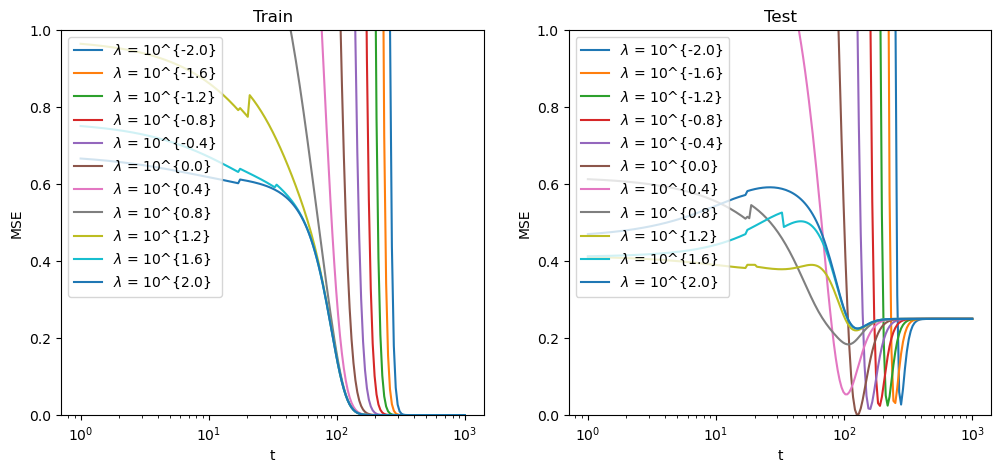

In [6]:
tau = 1000
res = 201
l_min, l_max = 0.01, 100

t_range = np.geomspace(1, tau, res)
l_range = np.geomspace(l_min, l_max, res)
ts, ls = np.meshgrid(t_range, l_range)

c, r = 0.001, 0.01

mset_1, mset_2 = mse_train(c, r, s, s, l1, ls, d, p2, u0, ts)
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, ls, e, e, d, p2, u0, ts)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, l_range, vmax=1.0, log_y_scale=True, fig_name="change_lambda_gamma_small")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=l_range, it=r"$\lambda$", ylim=1, log_y_scale=True, fig_name="change_l_gamma_small")


## c = r

C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:5: RuntimeWarning: overflow encountered in exp
  n = s * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) + c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:6: RuntimeWarning: overflow encountered in exp
  d = l * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) - 2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:8: RuntimeWarning: invalid value encountered in divide
  return n / d


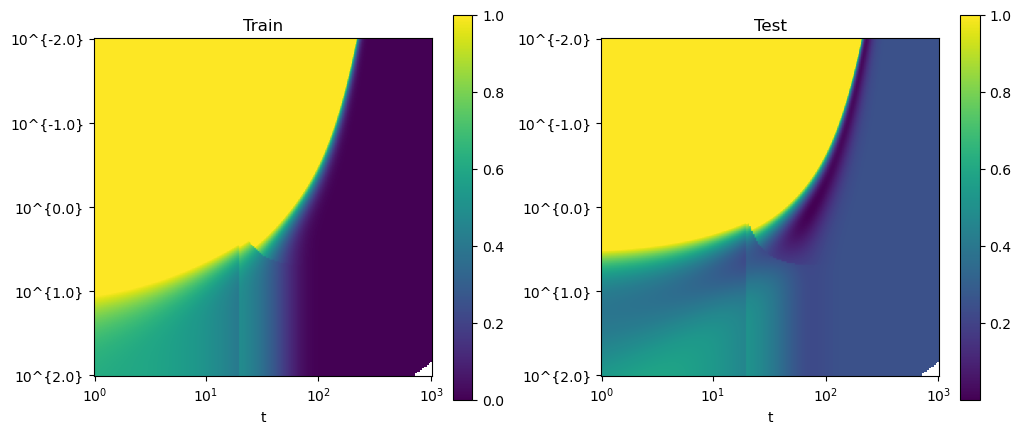

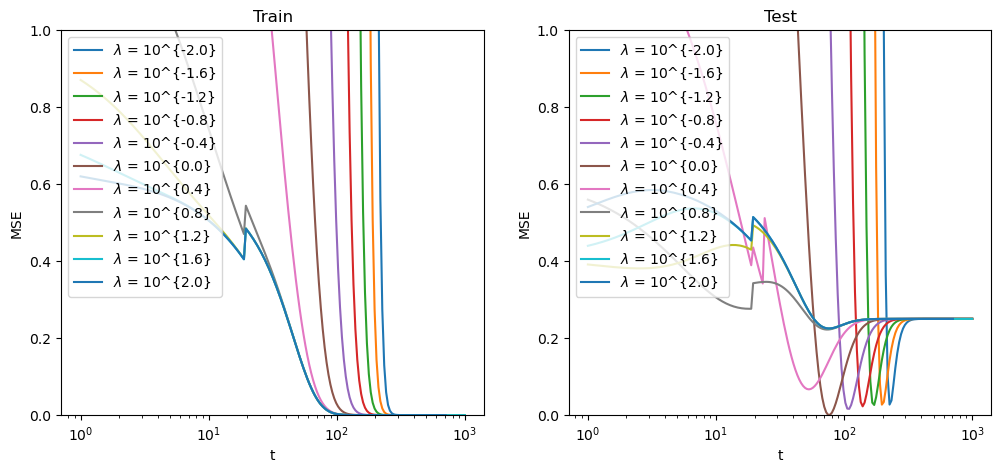

In [7]:
# HÄR

c, r = 0.01, 0.01 # Här är max(ru) = r * s/l, min(ru) = r * u0, så vi kommer att ha ett skifte c > r vid något l

mset_1, mset_2 = mse_train(c, r, s, s, l1, ls, d, p2, u0, ts)
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, ls, e, e, d, p2, u0, ts)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, l_range, vmax=1.0, log_y_scale=True, fig_name="change_lambda_gamma_equal")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=l_range, it=r"$\lambda$", ylim=1, log_y_scale=True, fig_name="change_l_gamma_equal")


## c > r

C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:5: RuntimeWarning: overflow encountered in exp
  n = s * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) + c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:6: RuntimeWarning: overflow encountered in exp
  d = l * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) - 2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:8: RuntimeWarning: invalid value encountered in divide
  return n / d


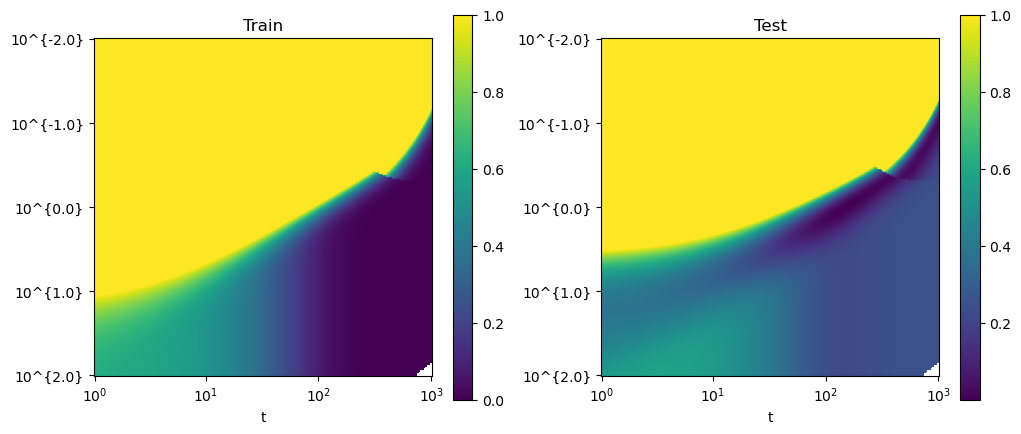

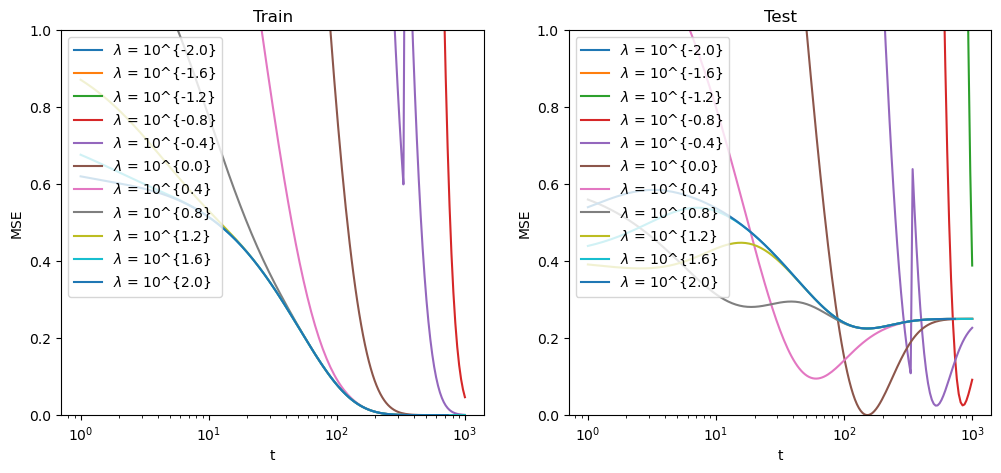

In [8]:
c, r = 0.01, 0.001

mset_1, mset_2 = mse_train(c, r, s, s, l1, ls, d, p2, u0, ts)
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, ls, e, e, d, p2, u0, ts)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, l_range, vmax=1.0, log_y_scale=True, fig_name="change_lambda_gamma_large")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=l_range, it=r"$\lambda$", ylim=1, log_y_scale=True, fig_name="change_l_gamma_large")


## c > r, changed order of approx.

C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:5: RuntimeWarning: overflow encountered in exp
  n = s * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) + c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:6: RuntimeWarning: overflow encountered in exp
  d = l * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) - 2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:8: RuntimeWarning: invalid value encountered in divide
  return n / d


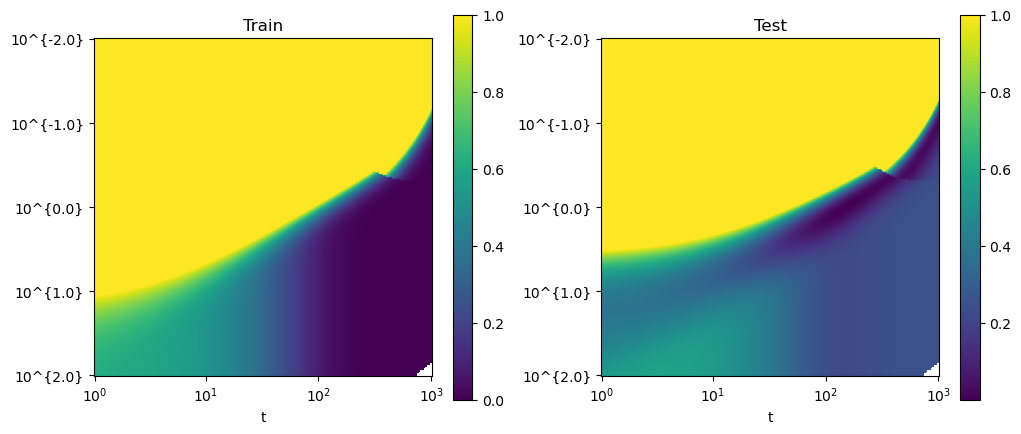

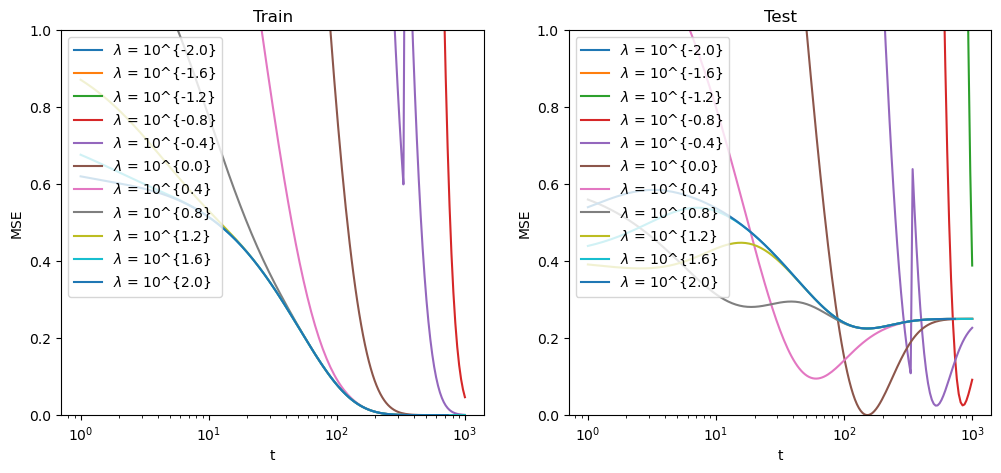

In [9]:
c, r = 0.01, 0.001

mset_1, mset_2 = mse_train(c, r, s, s, l1, ls, d, p2, u0, ts)
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, ls, e, e, d, p2, u0, ts)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, l_range, vmax=1.0, log_y_scale=True, fig_name="change_lambda_gamma_large_rev_order")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=l_range, it=r"$\lambda$", ylim=1, log_y_scale=True, fig_name="change_l_gamma_large_rev_order")


## c = 0

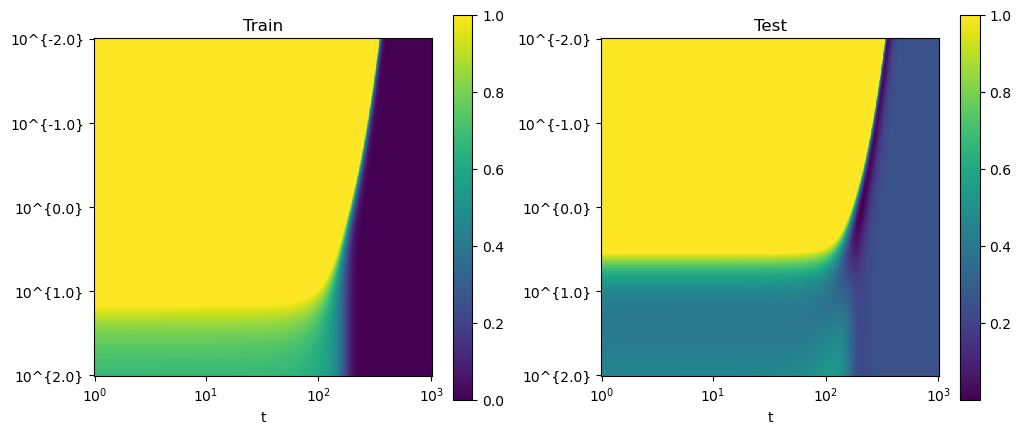

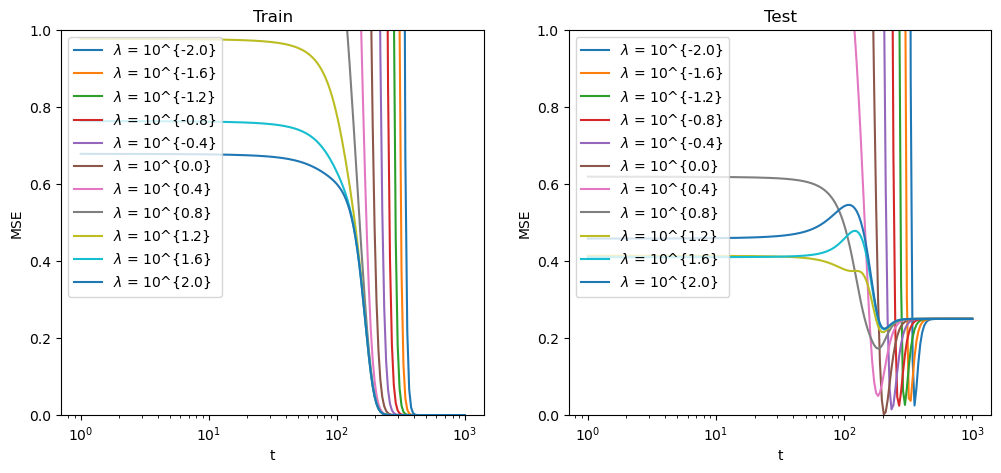

In [10]:
c, r = 0.0, 0.01

mset_1, mset_2 = mse_train(c, r, s, s, l1, ls, d, p2, u0, ts)
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, ls, e, e, d, p2, u0, ts)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, l_range, vmax=1.0, log_y_scale=True, fig_name="change_lambda_gamma_zero")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=l_range, it=r"$\lambda$", ylim=1, log_y_scale=True, fig_name="change_l_gamma_zero")

# Här förväntar vi oss på ett sätt inte double descent: men l avgör också avståndet till sanna vikten

## r = 0

C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:5: RuntimeWarning: overflow encountered in exp
  n = s * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) + c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:6: RuntimeWarning: overflow encountered in exp
  d = l * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) - 2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:8: RuntimeWarning: invalid value encountered in divide
  return n / d


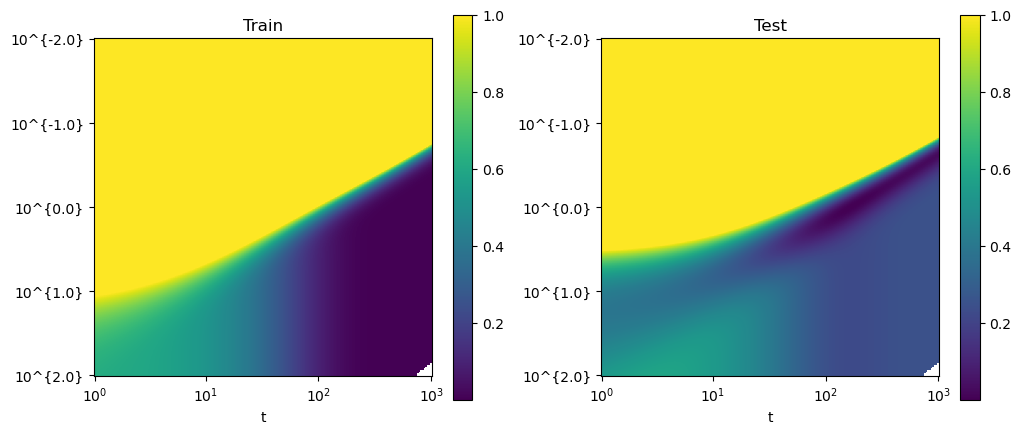

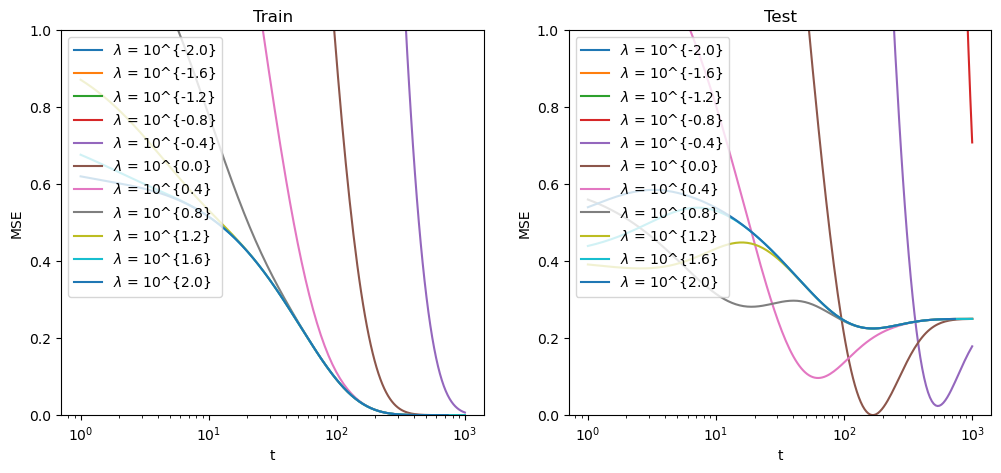

In [11]:
c, r = 0.01, 0.0

mset_1, mset_2 = mse_train(c, r, s, s, l1, ls, d, p2, u0, ts)
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, ls, e, e, d, p2, u0, ts)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, l_range, vmax=1.0, log_y_scale=True, fig_name="change_lambda_gamma_only_rev_order")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=l_range, it=r"$\lambda$", ylim=1, log_y_scale=True, fig_name="change_l_gamma_only_rev_order")


# Changing $s={\lambda^{(yx)}}^{1/2}$

## c < r

C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:5: RuntimeWarning: overflow encountered in exp
  n = s * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) + c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:6: RuntimeWarning: overflow encountered in exp
  d = l * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) - 2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:8: RuntimeWarning: invalid value encountered in divide
  return n / d


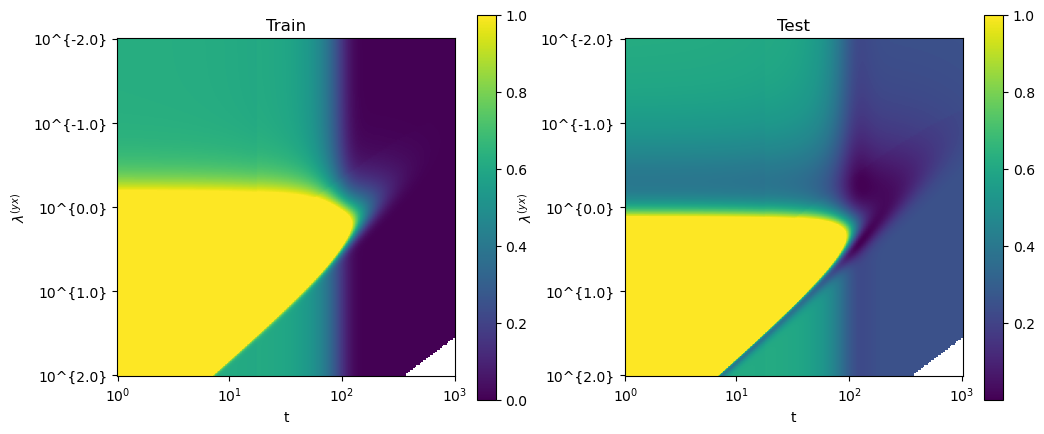

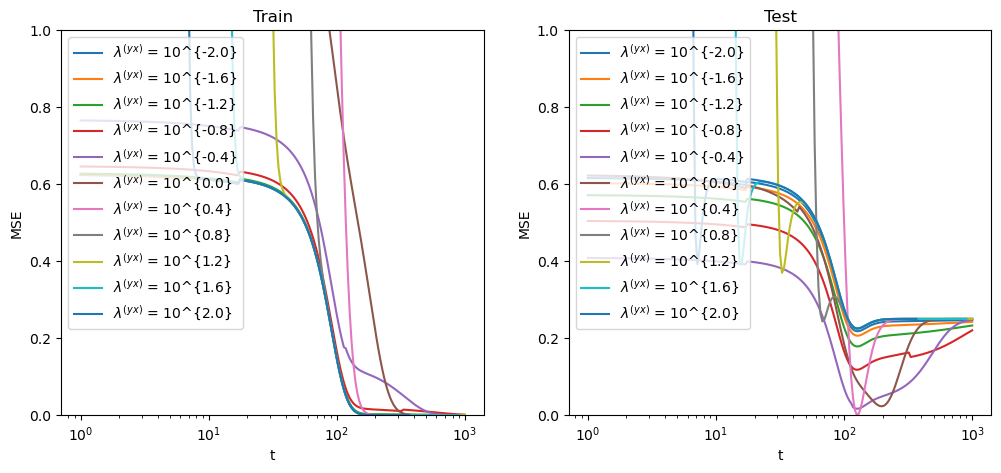

In [12]:
s_min, s_max = 0.01, 100
s_range = np.geomspace(s_min, s_max, res)

ts2, ss = np.meshgrid(t_range, s_range)

c, r = 0.001, 0.01

mset_1, mset_2 = mse_train(c, r, s, ss, l1, l1, d, p2, u0, ts2)
mseg_1, mseg_2 = mse_test(c, r, s, ss, l1, l1, e, e, d, p2, u0, ts2)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, s_range, it=r"$\lambda^{(yx)}$", vmax=1.0, fig_name="change_lambdayx_gamma_small")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=s_range, it=r"$\lambda^{(yx)}$", ylim=1, fig_name="change_lambdayx_gamma_small")

## c = r

C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:5: RuntimeWarning: overflow encountered in exp
  n = s * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) + c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:6: RuntimeWarning: overflow encountered in exp
  d = l * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) - 2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:8: RuntimeWarning: invalid value encountered in divide
  return n / d


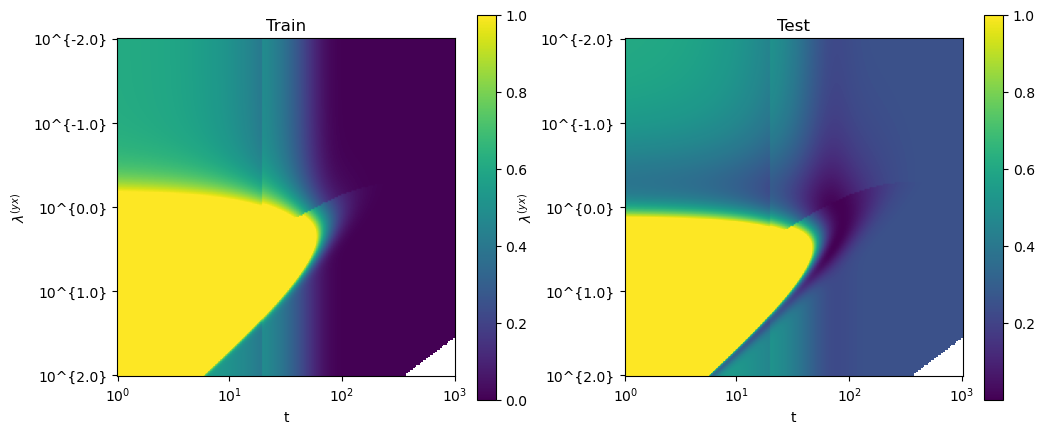

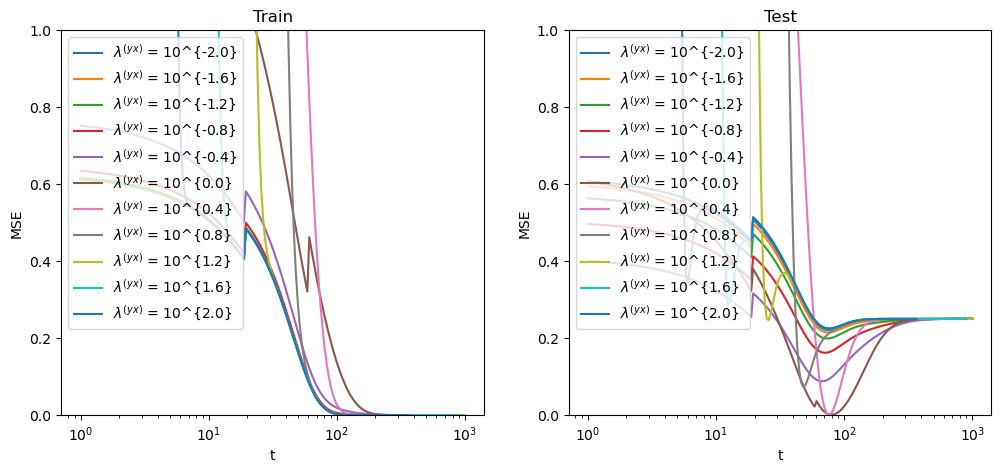

In [13]:
c, r = 0.01, 0.01

mset_1, mset_2 = mse_train(c, r, s, ss, l1, l1, d, p2, u0, ts2)
mseg_1, mseg_2 = mse_test(c, r, s, ss, l1, l1, e, e, d, p2, u0, ts2)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, s_range, it=r"$\lambda^{(yx)}$", vmax=1.0, fig_name="change_lambdayx_gamma_equal")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=s_range, it=r"$\lambda^{(yx)}$", ylim=1, fig_name="change_lambdayx_gamma_equal")

## c > r

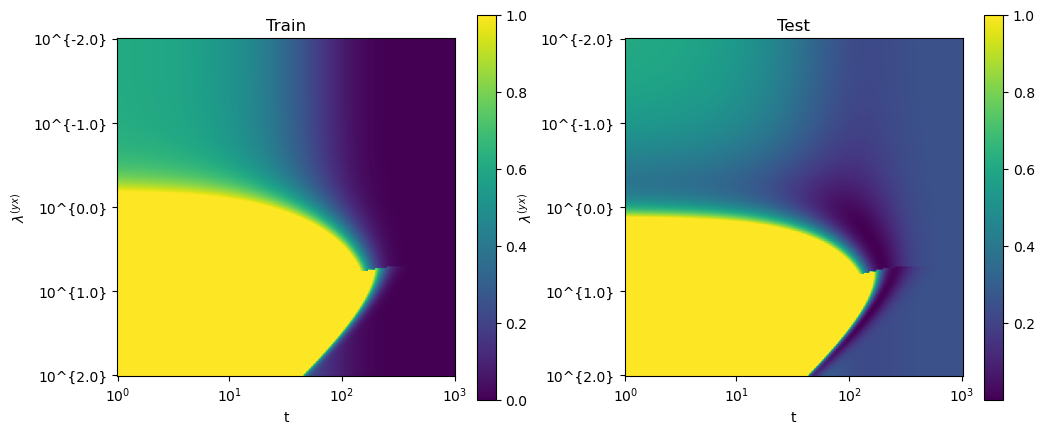

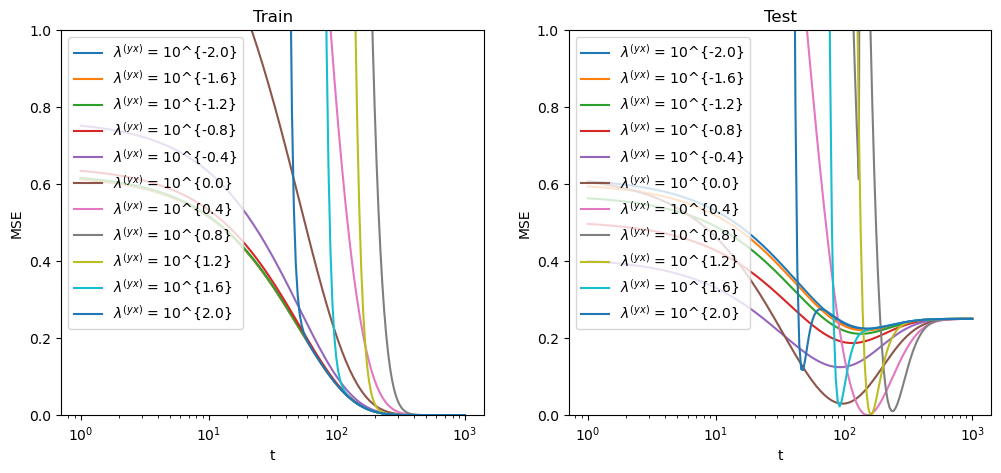

In [14]:
c, r = 0.01, 0.001

mset_1, mset_2 = mse_train(c, r, s, ss, l1, l1, d, p2, u0, ts2)
mseg_1, mseg_2 = mse_test(c, r, s, ss, l1, l1, e, e, d, p2, u0, ts2)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, s_range, it=r"$\lambda^{(yx)}$", vmax=1.0, fig_name="change_lambdayx_gamma_large")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=s_range, it=r"$\lambda^{(yx)}$", ylim=1, fig_name="change_lambdayx_gamma_large")

## c = 0

C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:5: RuntimeWarning: overflow encountered in exp
  n = s * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) + c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:6: RuntimeWarning: overflow encountered in exp
  d = l * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) - 2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:8: RuntimeWarning: invalid value encountered in divide
  return n / d


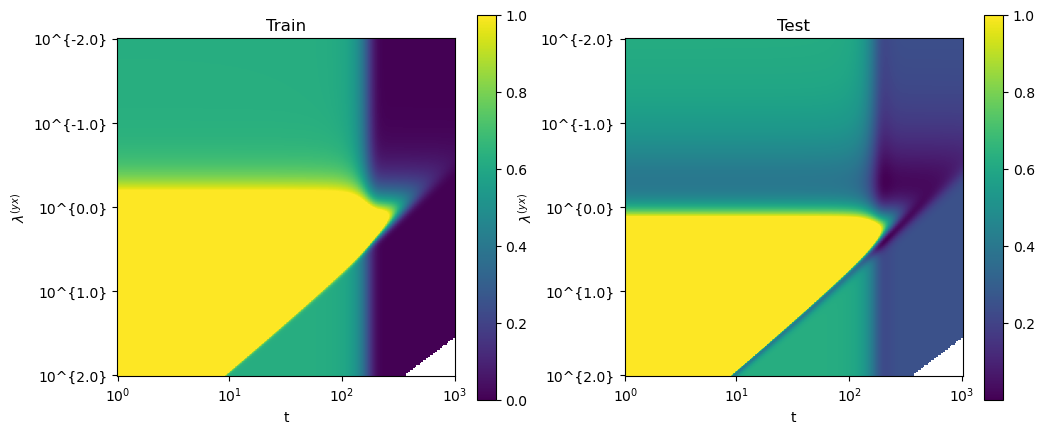

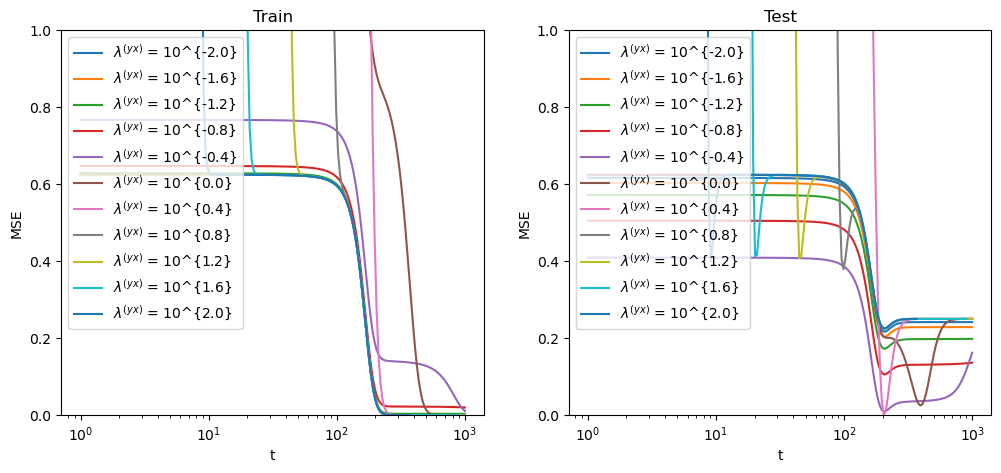

In [15]:
# Kolla på när vi har och inte har ett "steg" i träningsfelet

c, r = 0.0, 0.01

mset_1, mset_2 = mse_train(c, r, s, ss, l1, l1, d, p2, u0, ts2)
mseg_1, mseg_2 = mse_test(c, r, s, ss, l1, l1, e, e, d, p2, u0, ts2)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, s_range, it=r"$\lambda^{(yx)}$", vmax=1.0, fig_name="change_lambdayx_gamma_zero")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=s_range, it=r"$\lambda^{(yx)}$", ylim=1, fig_name="change_lambdayx_gamma_zero")

## r = 0

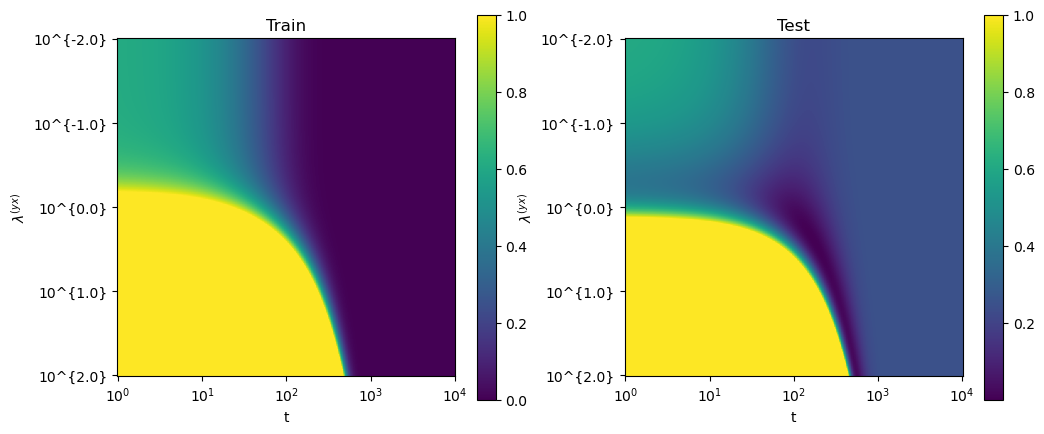

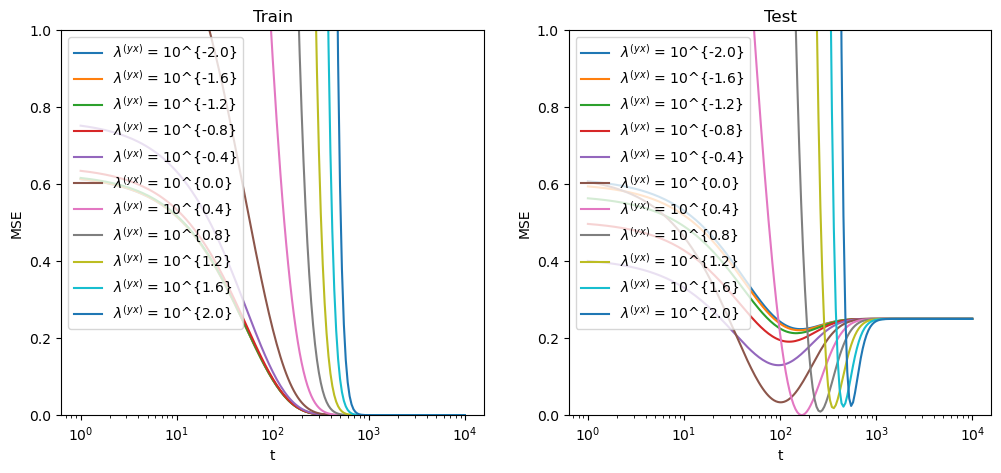

In [16]:
tau2 = 10000
t_range2 = np.geomspace(1, tau2, res)
ts2b, ss2 = np.meshgrid(t_range2, s_range)

c, r = 0.01, 0.0

mset_1, mset_2 = mse_train(c, r, s, ss2, l1, l1, d, p2, u0, ts2b)
mseg_1, mseg_2 = mse_test(c, r, s, ss2, l1, l1, e, e, d, p2, u0, ts2b)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range2, s_range, it=r"$\lambda^{(yx)}$", vmax=1.0, fig_name="change_lambdayx_gamma_only_rev_order")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range2, it_range=s_range, it=r"$\lambda^{(yx)}$", ylim=1, fig_name="change_lambdayx_gamma_only_rev_order")

# Changing $u0=u(0)$ (Obs! Eg. vill vi ha olika u0 för olika l)

## c < r

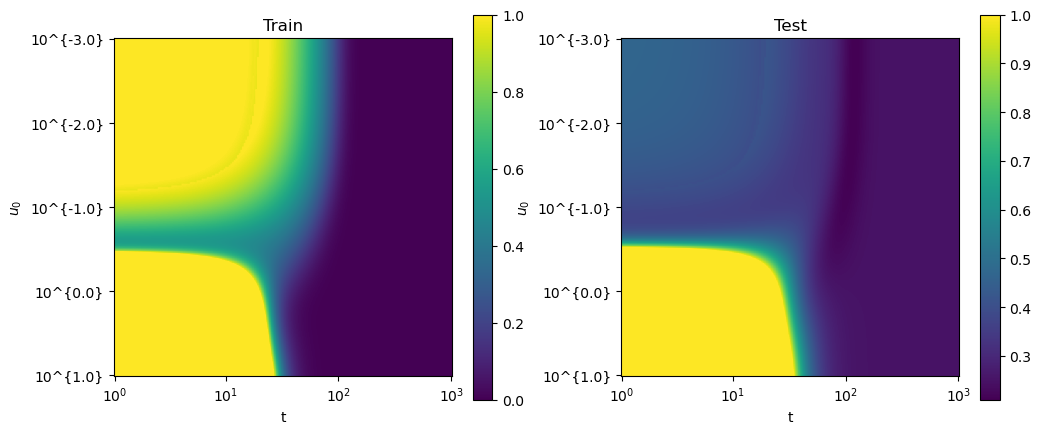

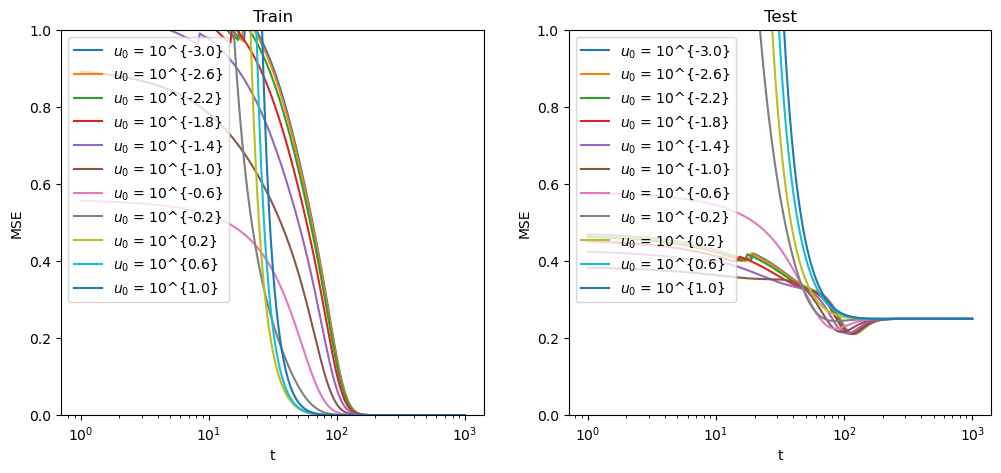

In [17]:
# u(0) will affect whether or not we pass the true minima

u0_min, u0_max = 0.001, 10
u0_range = np.geomspace(u0_min, u0_max, res)

ts3, u0s = np.meshgrid(t_range, u0_range)

c, r = 0.001, 0.01

# OBS! Different l!
mset_1, mset_2 = mse_train(c, r, s, s, l1, l2, d, p2, u0s, ts3)
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, l2, e, e, d, p2, u0s, ts3)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, u0_range, it=r"$u_0$", vmax=1.0, fig_name="change_u0_gamma_small")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=u0_range, it=r"$u_0$", ylim=1, log_y_scale=True, fig_name="change_u0_gamma_small")


## c = r

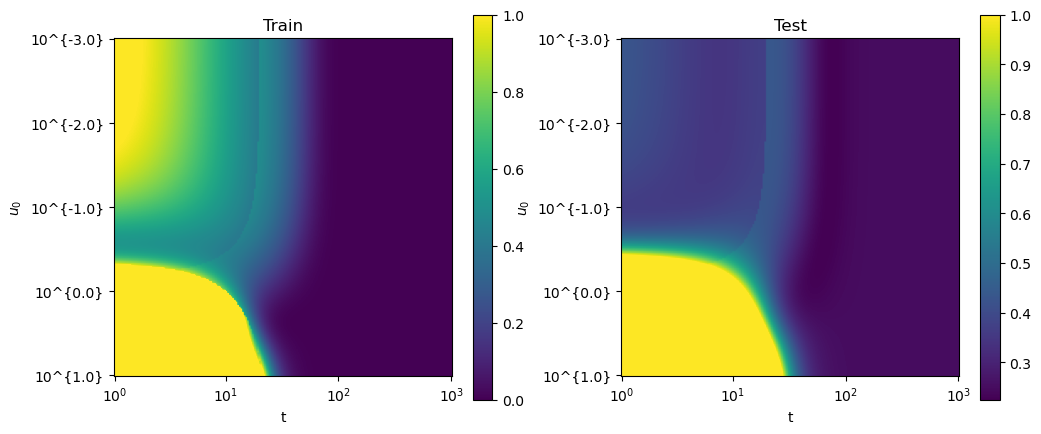

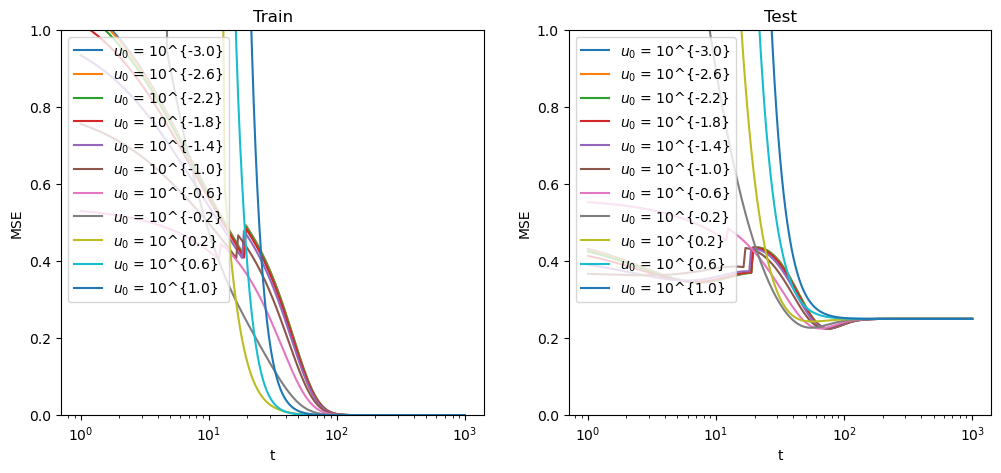

In [18]:
c, r = 0.01, 0.01

# OBS! Different l!
mset_1, mset_2 = mse_train(c, r, s, s, l1, l2, d, p2, u0s, ts3)
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, l2, e, e, d, p2, u0s, ts3)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, u0_range, it=r"$u_0$", vmax=1.0, fig_name="change_u0_gamma_equal")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=u0_range, it=r"$u_0$", ylim=1, log_y_scale=True, fig_name="change_u0_gamma_equal")


## c > r

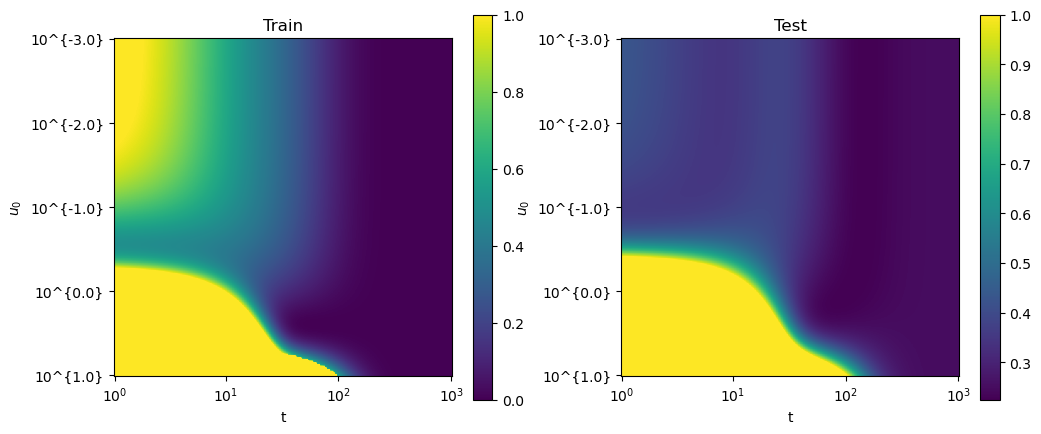

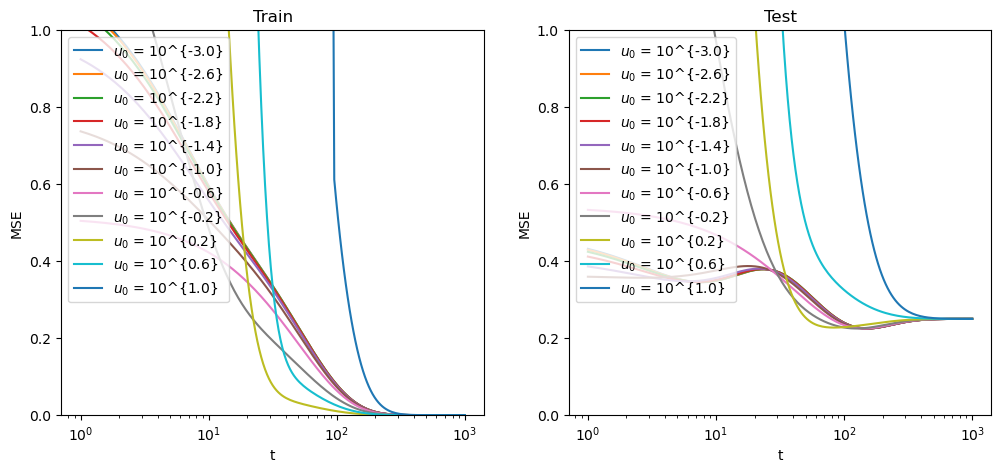

In [19]:
c, r = 0.01, 0.001

# OBS! Different l!
mset_1, mset_2 = mse_train(c, r, s, s, l1, l2, d, p2, u0s, ts3)
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, l2, e, e, d, p2, u0s, ts3)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, u0_range, it=r"$u_0$", vmax=1.0, fig_name="change_u0_gamma_large")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=u0_range, it=r"$u_0$", ylim=1, log_y_scale=True, fig_name="change_u0_gamma_large")


## c = 0

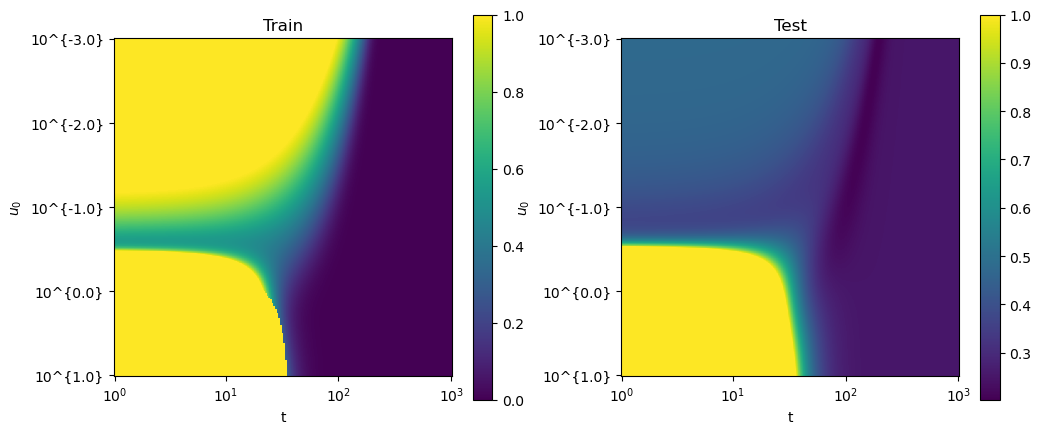

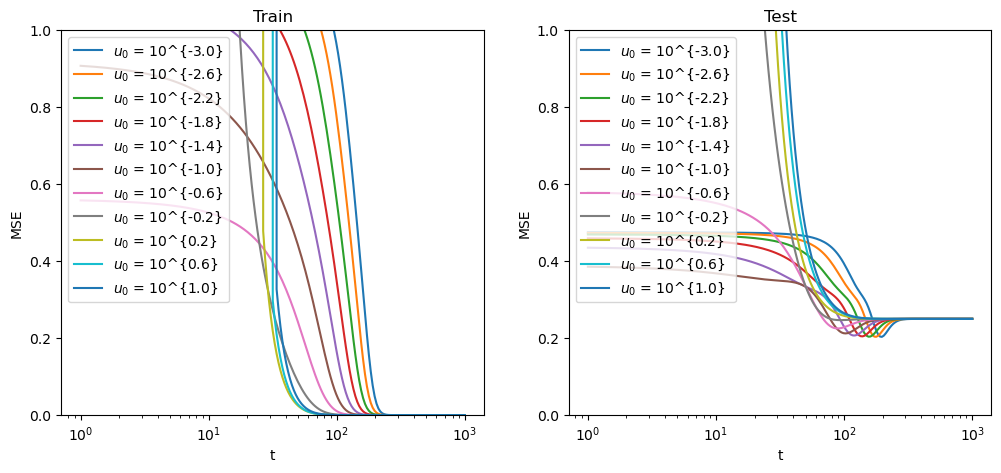

In [20]:
## c = r

c, r = 0.0, 0.01

# OBS! Different l!
mset_1, mset_2 = mse_train(c, r, s, s, l1, l2, d, p2, u0s, ts3)
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, l2, e, e, d, p2, u0s, ts3)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, u0_range, it=r"$u_0$", vmax=1.0, fig_name="change_u0_gamma_zero")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=u0_range, it=r"$u_0$", ylim=1, log_y_scale=True, fig_name="change_u0_gamma_zero")


## r = 0

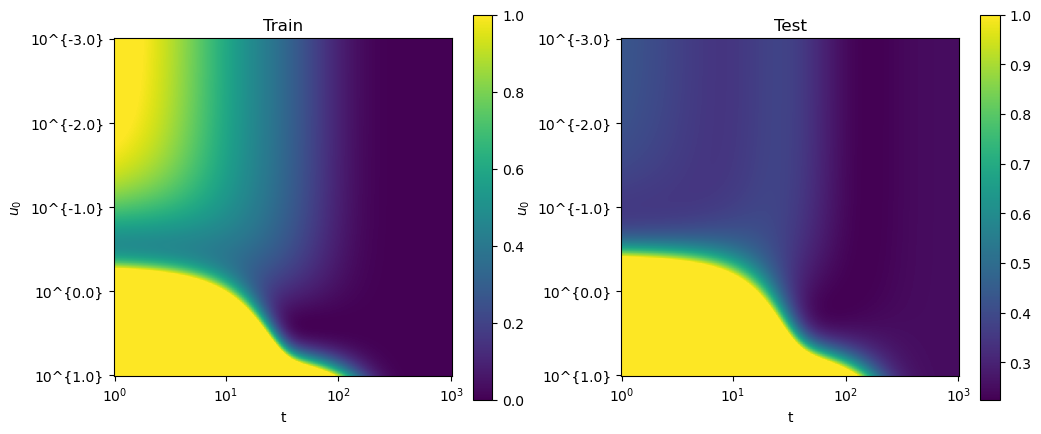

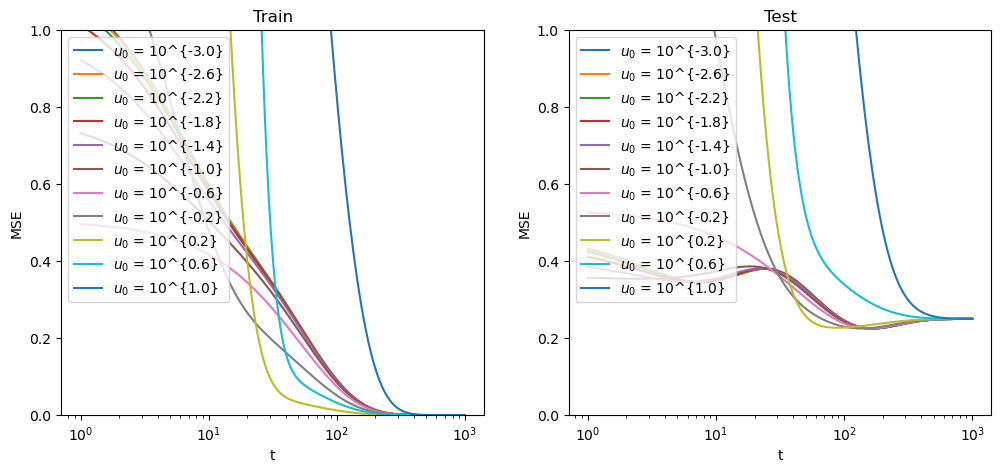

In [21]:
c, r = 0.01, 0.0

# OBS! Different l!
mset_1, mset_2 = mse_train(c, r, s, s, l1, l2, d, p2, u0s, ts3)
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, l2, e, e, d, p2, u0s, ts3)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, u0_range, it=r"$u_0$", vmax=1.0, fig_name="change_u0_gamma_only_rev_order")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=u0_range, it=r"$u_0$", ylim=1, log_y_scale=True, fig_name="change_u0_gamma_only_rev_order")


# Changing $r=2\sqrt{\eta_a \eta_b}$

### Different $l=\lambda$

C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:5: RuntimeWarning: overflow encountered in exp
  n = s * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) + c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:6: RuntimeWarning: overflow encountered in exp
  d = l * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) - 2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:8: RuntimeWarning: invalid value encountered in divide
  return n / d


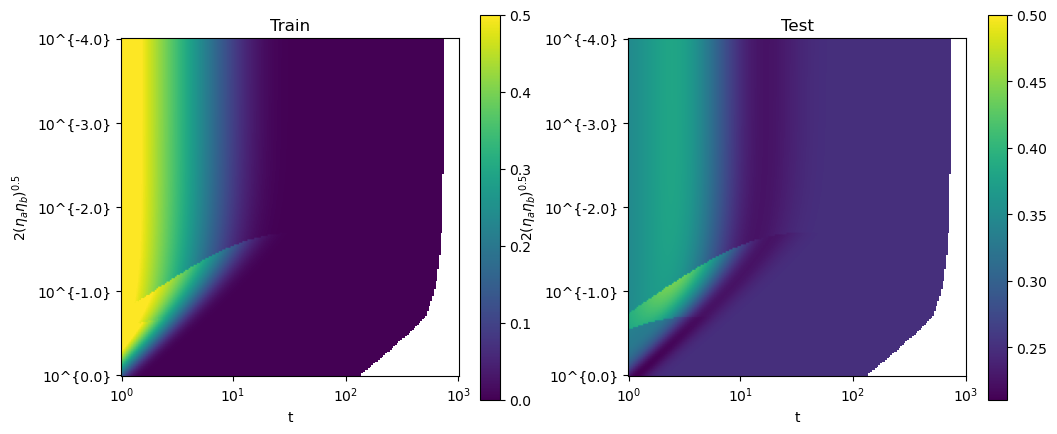

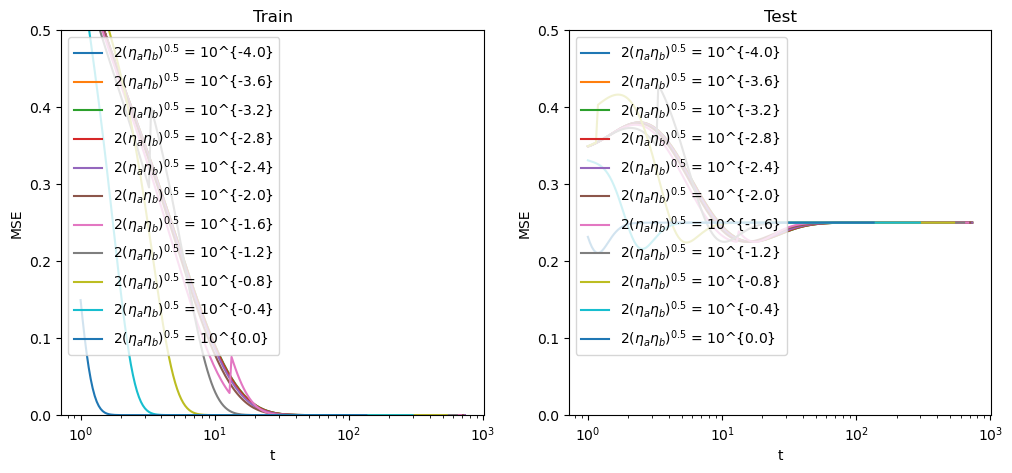

In [22]:
c = 0.1

r_min, r_max = 0.0001, 1.0
r_range = np.geomspace(r_min, r_max, res)
ts4, rs = np.meshgrid(t_range, r_range)

mset_1, mset_2 = mse_train(c, rs, s, s, l1, l2, d, p2, u0, ts4)
mseg_1, mseg_2 = mse_test(c, rs, s, s, l1, l2, e, e, d, p2, u0, ts4)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, r_range, it=fr"$2 (\eta_a \eta_b)^{{{1/2}}}$", vmax=0.5, fig_name="change_lr_gamma_fixed_different_lambda")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=r_range, it=fr"$2 (\eta_a \eta_b)^{{{1/2}}}$", ylim=0.5, fig_name="change_lr_gamma_fixed_different_lambda")


### Different $s = {\lambda^{(yx)}}^{1/2}$

C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:5: RuntimeWarning: overflow encountered in exp
  n = s * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) + c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:6: RuntimeWarning: overflow encountered in exp
  d = l * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) - 2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:8: RuntimeWarning: invalid value encountered in divide
  return n / d


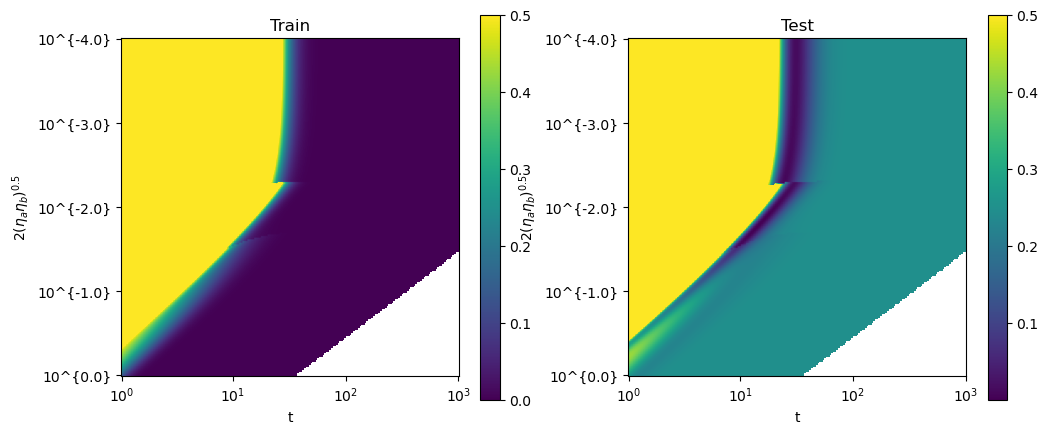

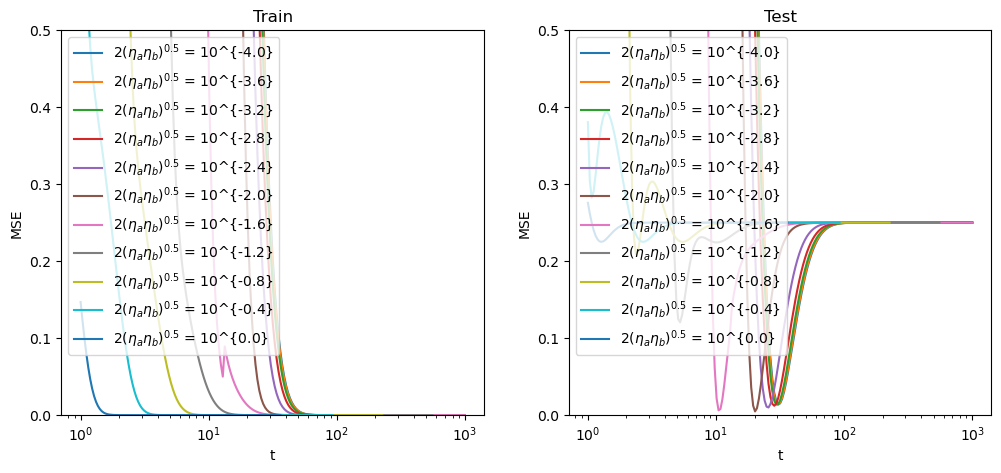

In [23]:
s2 = 10.0

mset_1, mset_2 = mse_train(c, rs, s, s2, l1, l1, d, p2, u0, ts4)
mseg_1, mseg_2 = mse_test(c, rs, s, s2, l1, l1, e, e, d, p2, u0, ts4)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, r_range, it=fr"$2 (\eta_a \eta_b)^{{{1/2}}}$", vmax=0.5, fig_name="change_lr_gamma_fixed_different_lambdayx")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=r_range, it=fr"$2 (\eta_a \eta_b)^{{{1/2}}}$", ylim=0.5, fig_name="change_lr_gamma_fixed_different_lambdayx")


# Changing $c = \gamma$

### Different $l=\lambda$

C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:5: RuntimeWarning: overflow encountered in exp
  n = s * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) + c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:6: RuntimeWarning: overflow encountered in exp
  d = l * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) - 2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:8: RuntimeWarning: invalid value encountered in divide
  return n / d
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:6: RuntimeWarning: overflow encountered in multiply
  d = l * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) - 2 * r * (l * u0 - s)


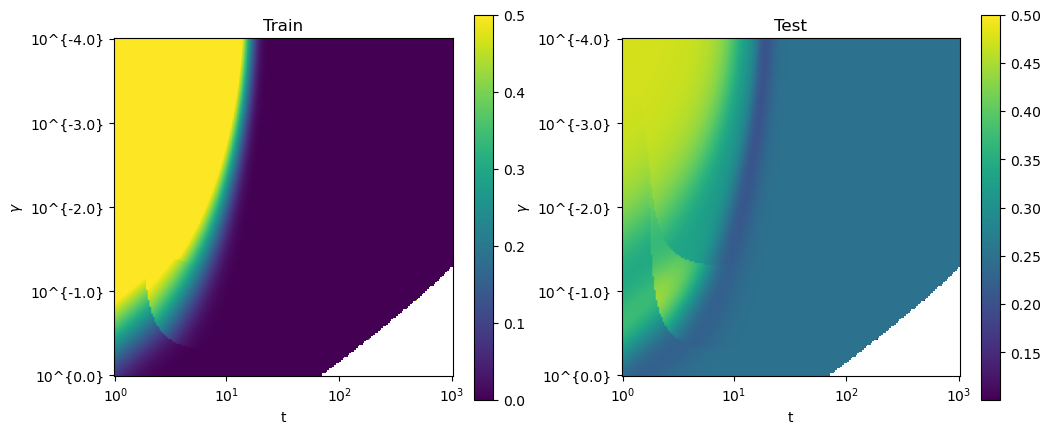

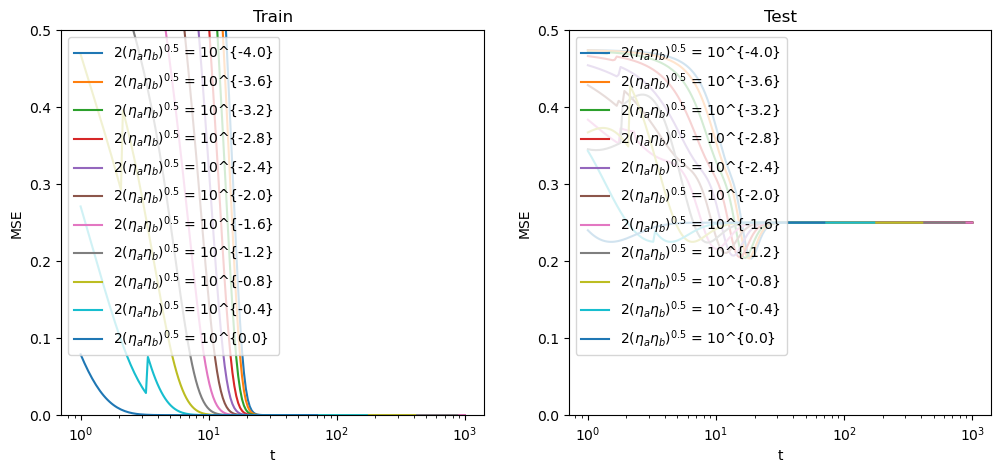

In [24]:
r = 0.1

c_min, c_max = 0.0001, 1.0
c_range = np.geomspace(c_min, c_max, res)
ts5, cs = np.meshgrid(t_range, c_range)

mset_1, mset_2 = mse_train(cs, r, s, s, l1, l2, d, p2, u0, ts5)
mseg_1, mseg_2 = mse_test(cs, r, s, s, l1, l2, e, e, d, p2, u0, ts5)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, c_range, it=fr"$\gamma$", vmax=0.5, fig_name="change_gamma_different_lambda")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=c_range, it=fr"$2 (\eta_a \eta_b)^{{{1/2}}}$", ylim=0.5, fig_name="change_lr_gamma_fixed_different_lambda")


### Different $s = {\lambda^{(yx)}}^{1/2}$

C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:5: RuntimeWarning: overflow encountered in exp
  n = s * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) + c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:6: RuntimeWarning: overflow encountered in exp
  d = l * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) - 2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:8: RuntimeWarning: invalid value encountered in divide
  return n / d
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:5: RuntimeWarning: overflow encountered in multiply
  n = s * (r * u0 + c) * np.exp((c * l + 2 * r * s) * t) + c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_27244\681823377.py:18: RuntimeWarning: invalid value encountered in multiply
  return ref * u1 + (1 - ref) * u2


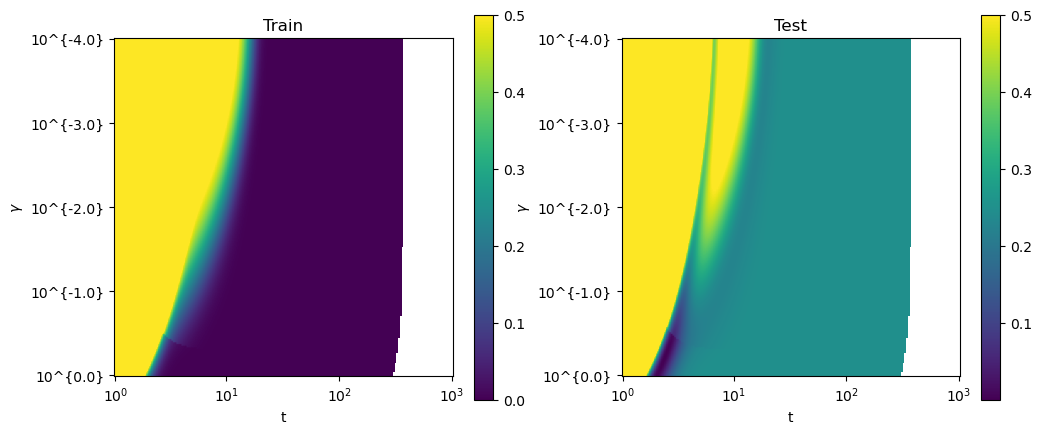

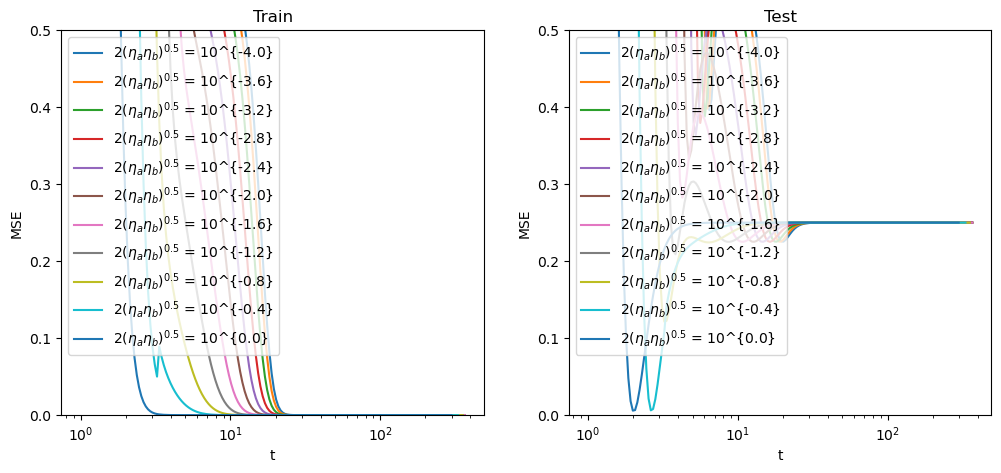

In [25]:
mset_1, mset_2 = mse_train(cs, r, s, s2, l1, l1, d, p2, u0, ts5)
mseg_1, mseg_2 = mse_test(cs, r, s, s2, l1, l1, e, e, d, p2, u0, ts5)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, c_range, it=fr"$\gamma$", vmax=0.5, fig_name="change_gamma_different_lambdayx")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=c_range, it=fr"$2 (\eta_a \eta_b)^{{{1/2}}}$", ylim=0.5, fig_name="change_lr_gamma_fixed_different_lambdayx")


# Changing $p$

## c = r, different $l=\lambda$

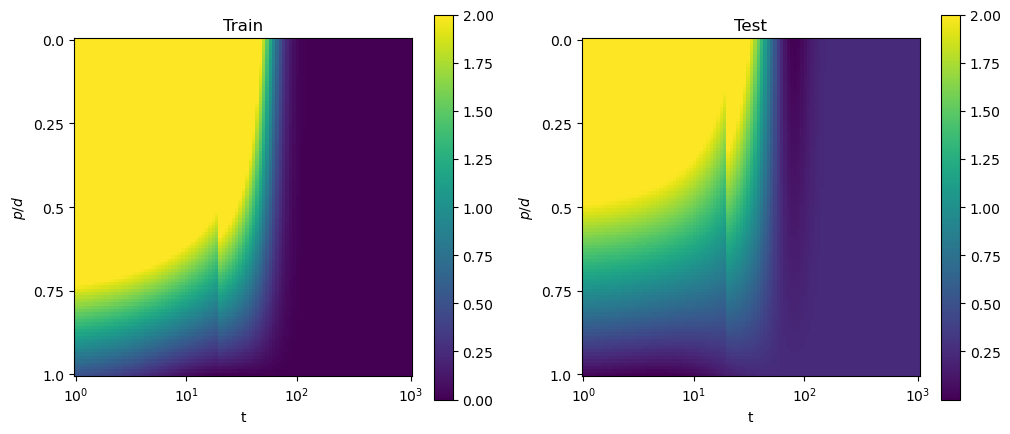

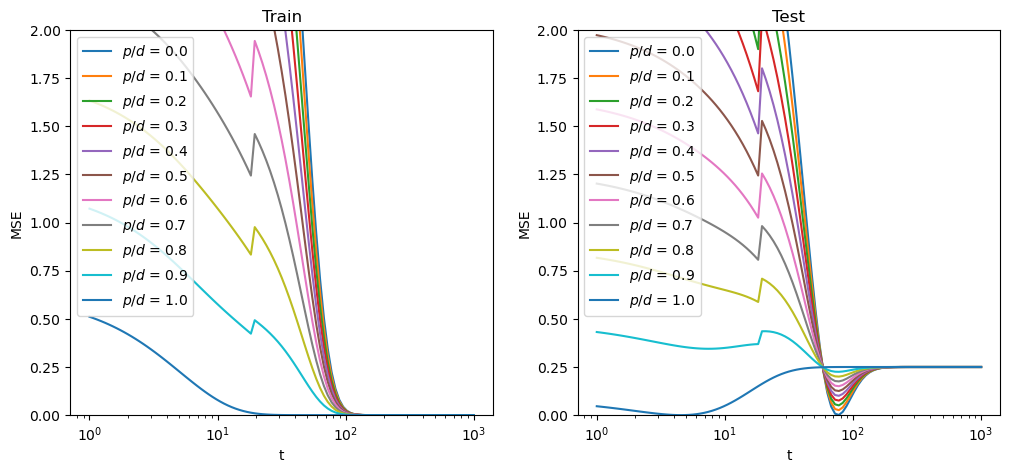

In [26]:
d2 = 100
p_min, p_max = 0, d2

res2 = 101
p_range = np.linspace(p_min, p_max, res2)
t_range3 = np.geomspace(1, tau, res2)
ts6, ps = np.meshgrid(t_range3, p_range)

c, r = 0.01, 0.01

mset_1, mset_2 = mse_train(c, r, s, s, l1, l2, d2, ps, u0, ts6)
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, l2, e, e, d2, ps, u0, ts6)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range3, p_range/d2, it=fr"$p/d$", vmax=2.0, fig_name="change_p_gamma_equal_different_lambda", log_y_scale=False)
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range3, it_range=p_range/d2, it=fr"$p/d$", ylim=2, fig_name="change_p_gamma_equal_different_lambda", log_y_scale=False)


## c = r, different $s={\lambda^{(yx)}}^{1/2}$

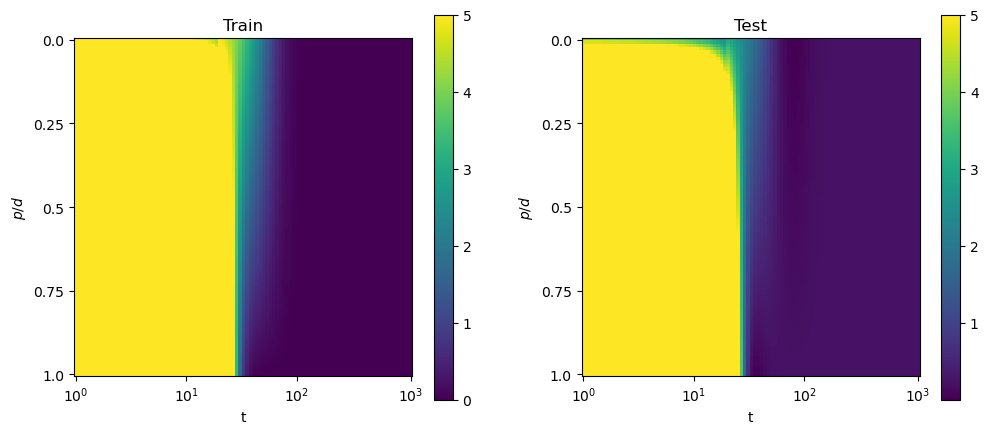

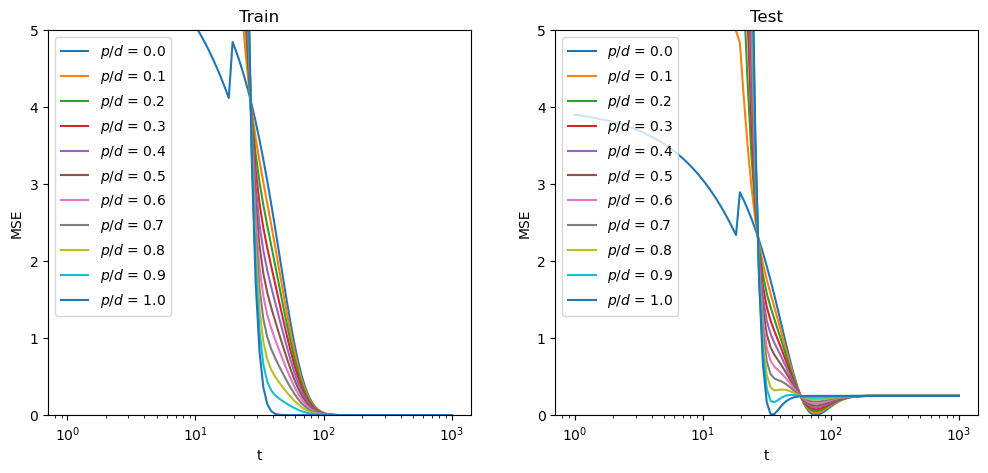

In [27]:
c, r = 0.01, 0.01

mset_1, mset_2 = mse_train(c, r, s, s2, l1, l1, d2, ps, u0, ts6)
mseg_1, mseg_2 = mse_test(c, r, s, s2, l1, l1, e, e, d2, ps, u0, ts6)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range3, p_range / d2, it=fr"$p / d$", vmax=5.0, fig_name="change_p_gamma_equal_different_lambdayx", log_y_scale=False)
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range3, it_range=p_range / d2, it=fr"$p / d$", ylim=5, fig_name="change_p_gamma_equal_different_lambda_yx", log_y_scale=False)


# Changing $e = \tilde{\epsilon}$

## c = r, different $l=\lambda$

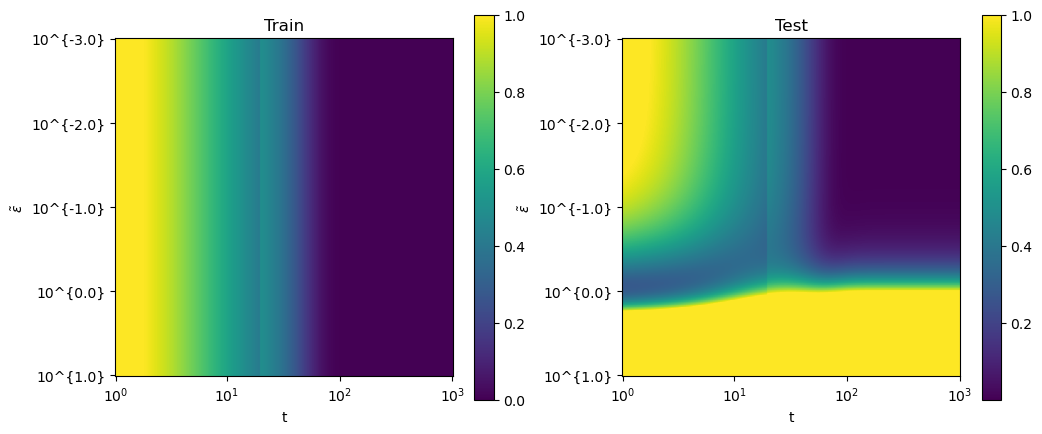

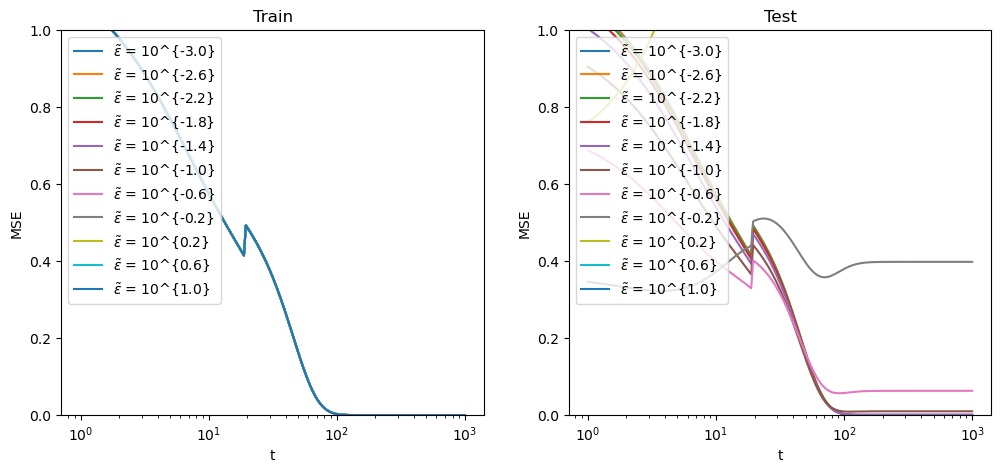

In [28]:
e_min, e_max = 0.001, 10
e_range = np.geomspace(e_min, e_max, res)

ts7, es = np.meshgrid(t_range, u0_range)

c, r = 0.01, 0.01

mset_1, mset_2 = mse_train(c, r, s, s, l1, l2, d, p2, u0, ts7)
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, l2, es, es, d, p2, u0, ts7)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, u0_range, it=r"$\tilde{\epsilon}$", vmax=1.0, fig_name="change_epsilon_gamma_equal_different_lambda")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=u0_range, it=r"$\tilde{\epsilon}$", ylim=1, log_y_scale=True, fig_name="change_epsilon_gamma_equal_different_lambda")


## c = r, different $s={\lambda^{(yx)}}^{1/2}$

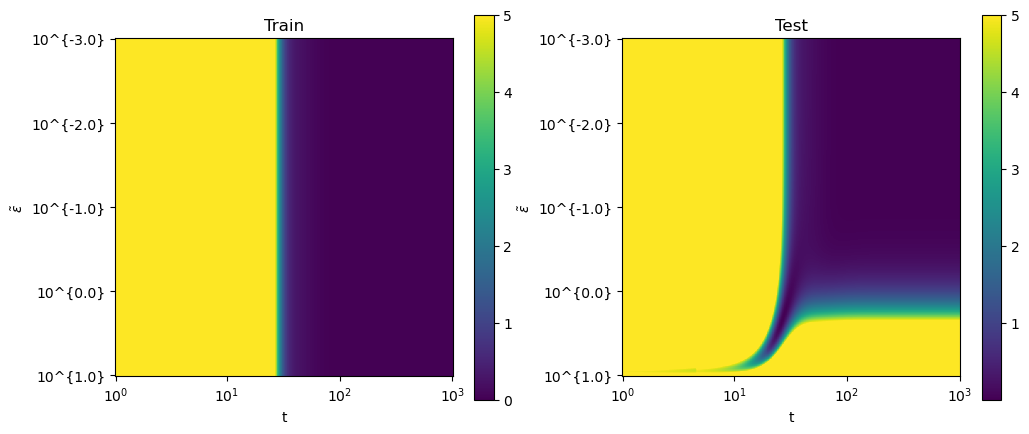

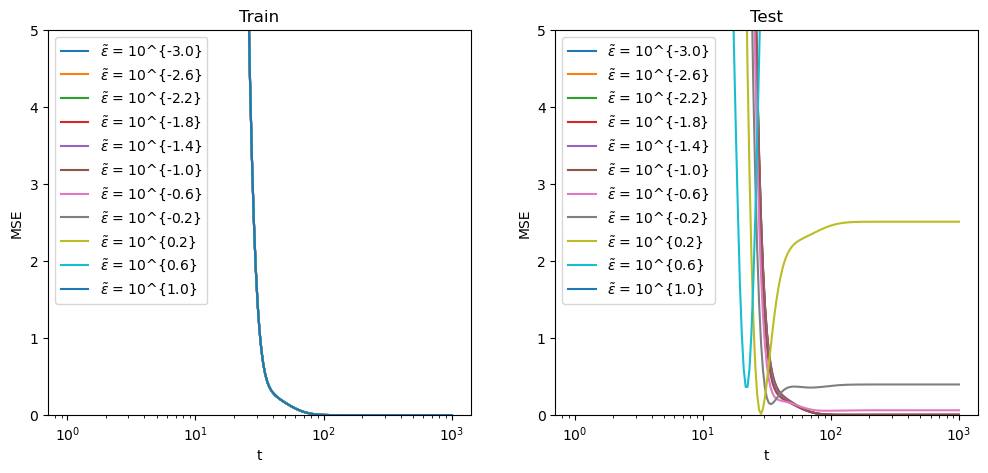

In [29]:
c, r = 0.01, 0.01

mset_1, mset_2 = mse_train(c, r, s, s2, l1, l1, d, p2, u0, ts7)
mseg_1, mseg_2 = mse_test(c, r, s, s2, l1, l1, es, es, d, p2, u0, ts7)

# Vis. 
plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, u0_range, it=r"$\tilde{\epsilon}$", vmax=5.0, fig_name="change_epsilon_gamma_equal_different_lambdayx")
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=u0_range, it=r"$\tilde{\epsilon}$", ylim=5, log_y_scale=True, fig_name="change_epsilon_gamma_equal_different_lambdayx")
